In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, wiener, medfilt

sns.set()

### Data preprocessing

In [113]:
df = pd.read_csv('SensorData/2Sens.csv')

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864864 entries, 0 to 864863
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   accX          864864 non-null  float64
 1   accY          864864 non-null  float64
 2   accZ          864864 non-null  float64
 3   gyrX          864864 non-null  float64
 4   gyrY          864864 non-null  float64
 5   gyrZ          864864 non-null  float64
 6   latitude      864864 non-null  float64
 7   longtitude    864864 non-null  float64
 8   speed         864864 non-null  int64  
 9   vehicleType   864864 non-null  int64  
 10  activityMode  864864 non-null  int64  
 11  timestamp     864864 non-null  object 
dtypes: float64(8), int64(3), object(1)
memory usage: 79.2+ MB


In [115]:
df['activityMode'].value_counts()

6    720323
5    139471
7      5070
Name: activityMode, dtype: int64

In [116]:
df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ,latitude,longtitude,speed,vehicleType,activityMode,timestamp
0,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,59.87523,29.899586,0,1,5,00:00:00.0048120
1,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,59.87523,29.899586,0,1,5,00:00:00.0058040
2,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,59.87523,29.899586,0,1,5,00:00:00.0102060
3,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,59.87523,29.899586,0,1,5,00:00:00.0108090
4,0.008870,0.007253,1.000837,0.001625,-0.00306,0.004771,59.87523,29.899586,0,1,5,00:00:00.0118610


In [117]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
accX,864864.0,-0.005912,7.999129e-02,-0.822671,-0.045583,-0.002409,0.034714,0.620041
accY,864864.0,0.001561,5.684004e-02,-0.697309,-0.024884,-0.000143,0.024958,0.654189
accZ,864864.0,1.003935,5.017684e-02,0.212520,0.981556,1.003945,1.026314,1.875643
gyrX,864864.0,-0.001832,1.976215e-02,-0.312360,-0.010592,-0.001429,0.007123,0.351040
gyrY,864864.0,-0.002131,5.267433e-02,-0.621256,-0.001228,0.004270,0.009157,0.518619
gyrZ,864864.0,0.002675,2.653891e-02,-0.276838,-0.008057,0.001106,0.010269,0.426268
latitude,864864.0,59.875230,4.614694e-10,59.875230,59.875230,59.875230,59.875230,59.875230
longtitude,864864.0,29.899586,3.761083e-10,29.899586,29.899586,29.899586,29.899586,29.899586
speed,864864.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
vehicleType,864864.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')

In [119]:
activities = {
    '5': df[df['activityMode'] == 5],
    '6': df[df['activityMode'] == 6],
    '7': df[df['activityMode'] == 7]
}

Text(0.5, 1.0, 'acc z')

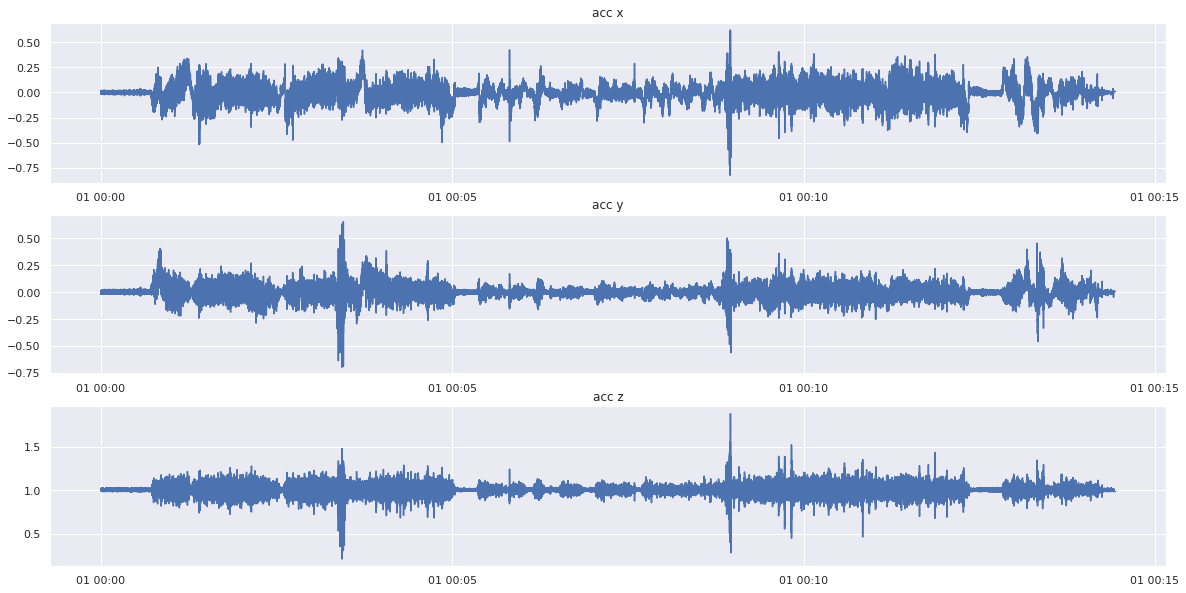

In [176]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(df['timestamp'], df['accX'])
ax[1].plot(df['timestamp'], df['accY'])
ax[2].plot(df['timestamp'], df['accZ'])
ax[0].set_title('acc x')
ax[1].set_title('acc y')
ax[2].set_title('acc z')



### Savitzky–Golay filter

In [213]:
result = savgol_filter(x=df['accX'], window_length=31, polyorder=2)

In [122]:
savgol_result = []
windows_length = range(3, 16, 2)
for i in windows_length:
    savgol_result.append(savgol_filter(x=df.loc[:100, 'accX'], window_length=i, polyorder=2))

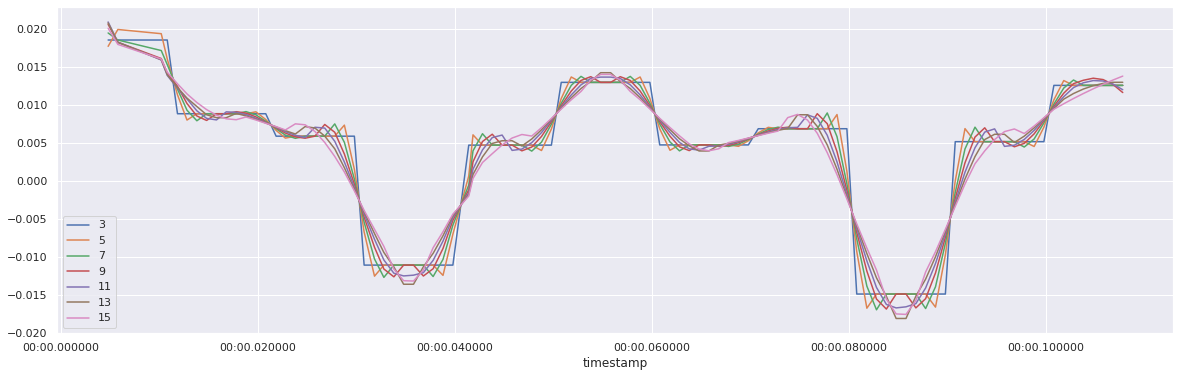

In [212]:
fig = plt.figure(figsize=(20, 6))
for i in savgol_result:
    ax = sns.lineplot(x=df.loc[:100, 'timestamp'], y=i)
ax.legend(windows_length)

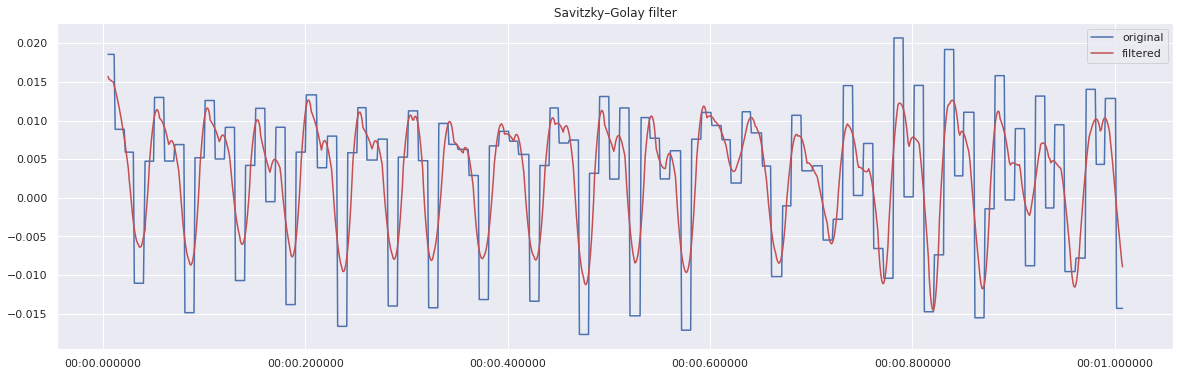

In [230]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df.loc[:1000, 'timestamp'], df.loc[:1000, 'accX'], label='original')
ax.plot(df.loc[:1000, 'timestamp'], result[:1001], 'r', label='filtered')
ax.set_title('Savitzky–Golay filter')
ax.legend()

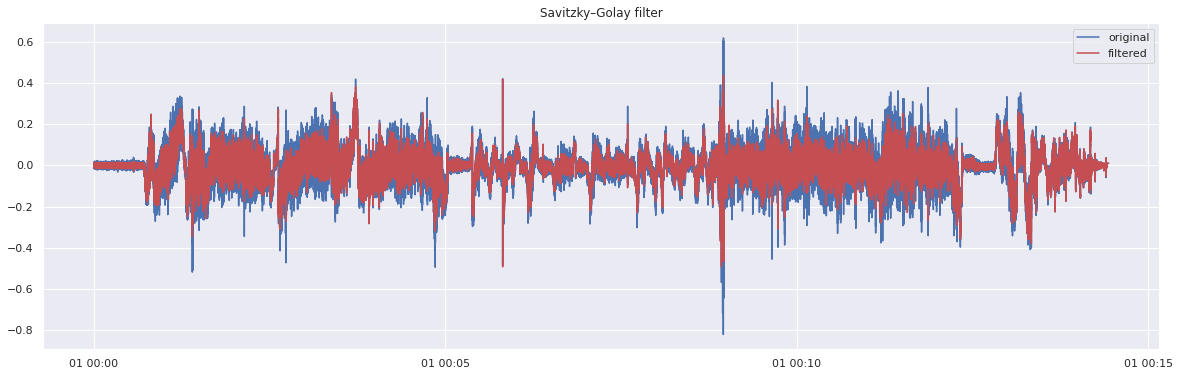

In [231]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['timestamp'], df['accX'], label='original')
ax.plot(df['timestamp'], result, 'r', label='filtered')
ax.set_title('Savitzky–Golay filter')
ax.legend()

### Wiener

In [194]:
result_wiener = wiener(df['accX'], 55)

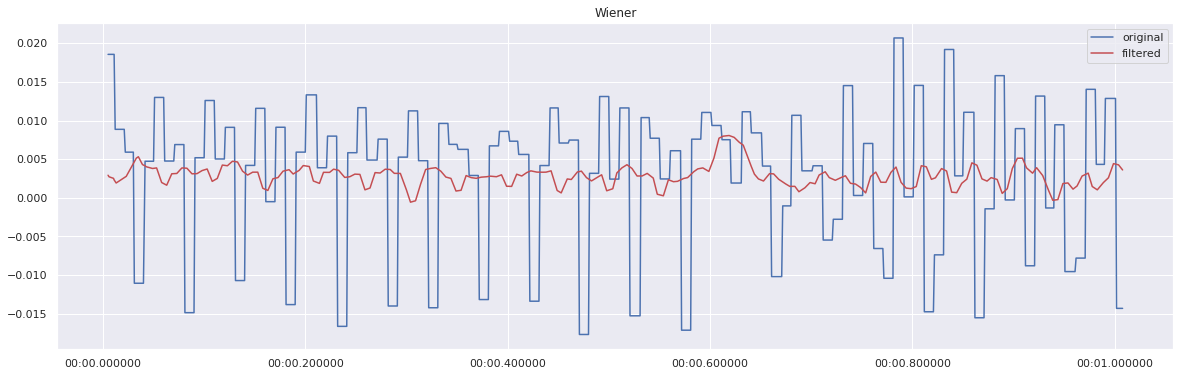

In [206]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df.loc[:1000, 'timestamp'], df.loc[:1000, 'accX'], label='original')
ax.plot(df.loc[:1000, 'timestamp'], result_wiener[:1001], 'r', label='filtered')
ax.set_title('Wiener')
ax.legend()

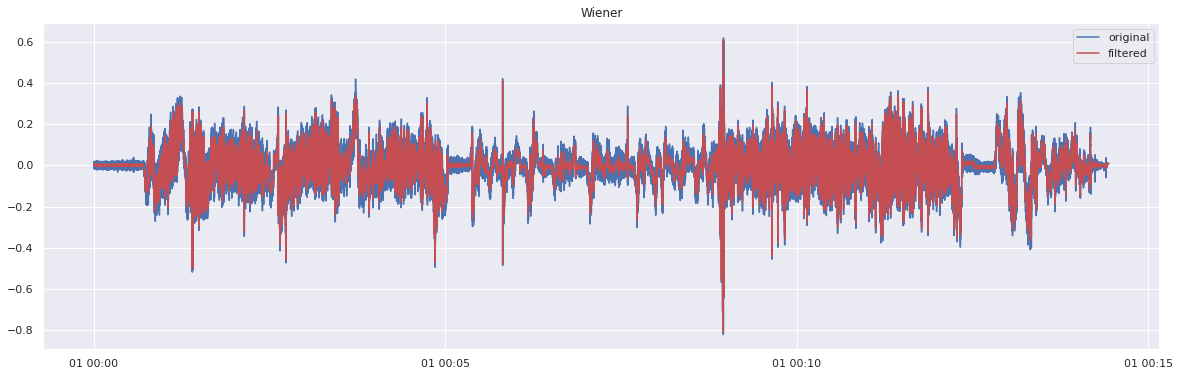

In [225]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['timestamp'], df['accX'], label='original')
ax.plot(df['timestamp'], result_wiener, 'r', label='filtered')
ax.set_title('Wiener')
ax.legend()

### Median filter

In [222]:
result_medfilt = medfilt(df['accX'], kernel_size=45)

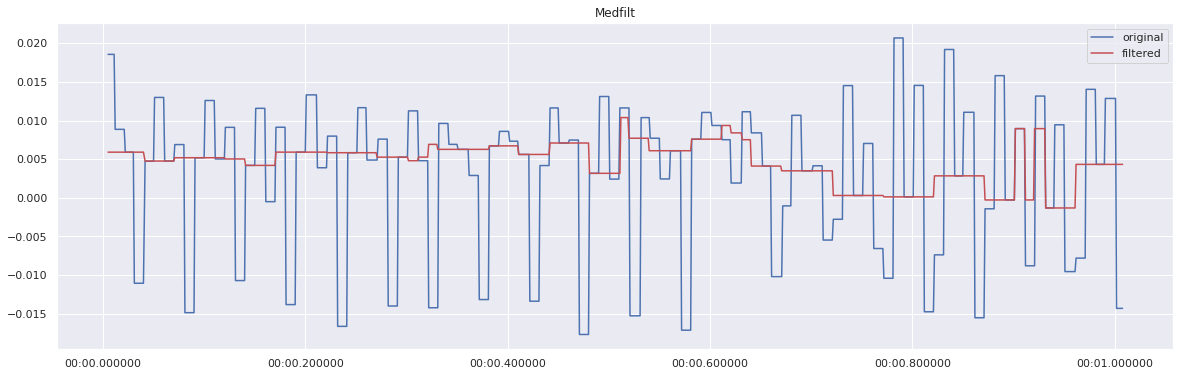

In [227]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df.loc[:1000, 'timestamp'], df.loc[:1000, 'accX'], label='original')
ax.plot(df.loc[:1000, 'timestamp'], result_medfilt[:1001], 'r', label='filtered')
ax.set_title('Medfilt')
ax.legend()

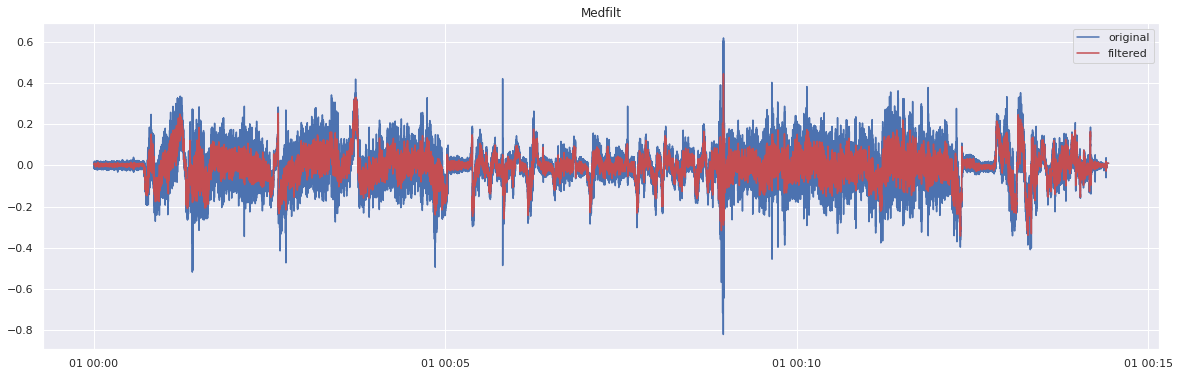

In [228]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['timestamp'], df['accX'], label='original')
ax.plot(df['timestamp'], result_medfilt, 'r', label='filtered')
ax.set_title('Medfilt')
ax.legend()

### Create model

In [129]:
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.utils import plot_model, to_categorical
from keras.preprocessing import timeseries_dataset_from_array
from scipy import stats

from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [130]:
df_train = df[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ', 'activityMode', 'timestamp']]

In [131]:
df_train['activityMode'] = df_train['activityMode'] - 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
df_train.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ,activityMode,timestamp
0,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,0,1900-01-01 00:00:00.004812
1,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,0,1900-01-01 00:00:00.005804
2,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,0,1900-01-01 00:00:00.010206
3,0.018576,-0.008798,1.005135,0.001625,-0.00306,0.004771,0,1900-01-01 00:00:00.010809
4,0.008870,0.007253,1.000837,0.001625,-0.00306,0.004771,0,1900-01-01 00:00:00.011861


In [133]:
df_train['activityMode'].value_counts()

1    720323
0    139471
2      5070
Name: activityMode, dtype: int64

In [134]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
        
def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data['accX'][start:end]
        y = data['accY'][start:end]
        z = data['accZ'][start:end]
        if(len(df_train['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data['activityMode'][start:end])[0][0])
    return segments, labels

In [135]:
segments, labels = segment_signal(df_train)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1, 90, 3)

In [136]:
segments.shape, labels.shape

((19218, 90, 3), (19218, 3))

In [148]:
train_x, test_x, train_y, test_y = train_test_split(segments, labels, test_size=0.20)

In [149]:
n_timestamps, n_features = train_x.shape[1], train_x.shape[2]

In [169]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(n_timestamps, n_features)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [170]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [171]:
history = model.fit(train_x, train_y, epochs=20, batch_size=30, validation_split=0.1)

Epoch 1/20
462/462 [==============================] - 16s 33ms/step - loss: 0.3740 - accuracy: 0.8624 - val_loss: 0.2730 - val_accuracy: 0.9005
Epoch 2/20
462/462 [==============================] - 15s 33ms/step - loss: 0.2186 - accuracy: 0.9174 - val_loss: 0.1893 - val_accuracy: 0.9330
Epoch 3/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1946 - accuracy: 0.9260 - val_loss: 0.2242 - val_accuracy: 0.9122
Epoch 4/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1917 - accuracy: 0.9314 - val_loss: 0.2114 - val_accuracy: 0.9005
Epoch 5/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1820 - accuracy: 0.9320 - val_loss: 0.1808 - val_accuracy: 0.9220
Epoch 6/20
462/462 [==============================] - 16s 34ms/step - loss: 0.1744 - accuracy: 0.9281 - val_loss: 0.2062 - val_accuracy: 0.9291
Epoch 7/20
462/462 [==============================] - 16s 34ms/step - loss: 0.1813 - accuracy: 0.9307 - val_loss: 0.1828 - val_accuracy:

In [172]:
model.evaluate(test_x, test_y)

121/121 [==============================] - 1s 5ms/step - loss: 0.1536 - accuracy: 0.9446


[0.15357759594917297, 0.9445889592170715]

In [173]:
model.save('cnn-1.hdf5')

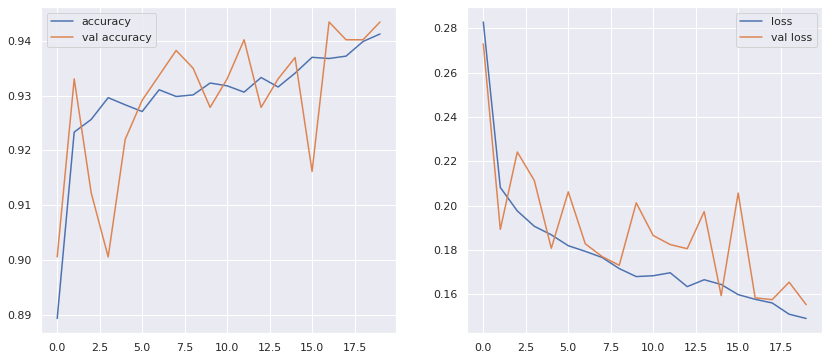

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(history.epoch, history.history['accuracy'], label='accuracy')
ax[0].plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
ax[1].plot(history.epoch, history.history['loss'], label='loss')
ax[1].plot(history.epoch, history.history['val_loss'], label='val loss')
ax[0].legend()

ax[1].legend()

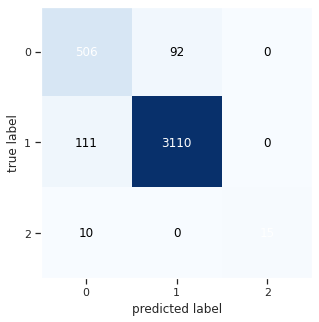

In [177]:
from sklearn.metrics import confusion_matrix
pred = model.predict(test_x)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_y, axis = 1)

CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()

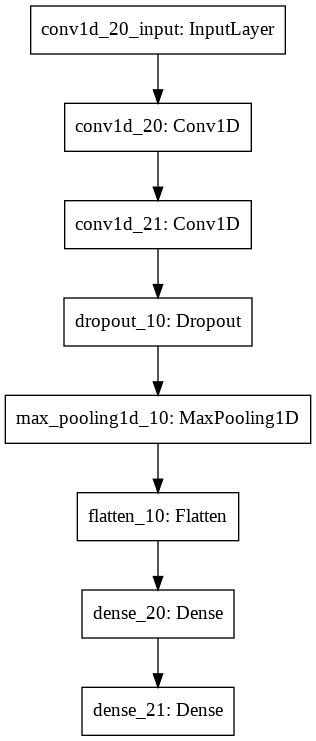

In [193]:
plot_model(model)